Importing libraries

In [219]:
import pandas
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

Managing file paths

In [220]:
folder_path = "C:\\Users\\AaronJacobsonDesk3\\Documents\\UWMSDS\\Classes\\Fall2021\\DATA512\\DATA512-A7\\"
covid_cases_file = "RAW_us_confirmed_cases.csv\\RAW_us_confirmed_cases.csv"
covid_policy_file = "U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv"
mask_use_file = "mask-use-by-county.csv"
mobility_file = "applemobilitytrends-2021-12-06.csv"
opentable_file = "2020-2021vs2019_Seated_Diner_Data.csv"

Initial reading in of data

In [221]:
df_cases = pandas.read_csv(folder_path + covid_cases_file)
df_policy = pandas.read_csv(folder_path + covid_policy_file)
df_masks = pandas.read_csv(folder_path + mask_use_file)
df_mobility = pandas.read_csv(folder_path + mobility_file)
df_table = pandas.read_csv(folder_path + opentable_file)

C:\Users\AaronJacobsonDesk3\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Filtering to just data from New York State

In [222]:
df_table = df_table[df_table['Name'] == 'New York']
df_table = df_table[df_table['Type'] == 'state']

Reshaping data to make it easier to measure and visualize

In [223]:
df_table_out = pandas.DataFrame(columns=['SecondDate', 'Table_Change', 'Table_Change%', 'Table_Level'])
last_col = '2020/2/18'
for index, row in df_table.iterrows():
    for col in df_table.columns:
        if col != 'Type' and col != '2020/2/18' and col != 'Name':
            now_level = 100 + float(row[col][:-1])
            last_level = 100 + float(row[last_col][:-1])
            ab_increase = now_level - last_level
            p_increase = 0.0
            if now_level != 0:
                p_increase = 1.0
            if last_level != 0:
                p_increase = ab_increase / last_level
            new_date = datetime.datetime.strptime(col, '%Y/%m/%d')
            
            if new_date.weekday() < 5 and new_date.weekday() != 0:
                df_table_out = df_table_out.append({'SecondDate': new_date, 'Table_Change': ab_increase, 'Table_Change%': p_increase, 'Table_Level': now_level}, ignore_index=True)
            last_col = col

Filtering mobility data to just New York

In [224]:
df_mobility_state = df_mobility[df_mobility['geo_type'] == 'sub-region']
df_mobility_state = df_mobility_state[df_mobility_state['region'] == 'New York']

Filtering cases data to just New York

In [225]:
df_cases = df_cases[df_cases['Province_State'] == 'New York']

merging and reshaping data for easier analysis

In [226]:
# remove unnecessary rows
df_cases_t = df_cases.drop([
    'Province_State', 
    'Admin2', 
    'UID', 
    'iso2', 
    'iso3', 
    'code3', 
    'FIPS', 
    'Country_Region', 
    'Lat', 
    'Long_',
    'Combined_Key'], axis=1).transpose().rename({1943:'Cases'}, axis=1)
# select the chosen county, hardcoded because of the difference in values between files
df_policy_queens = df_policy[df_policy['County_Name'] == 'Queens County']
# saving the FIPS code for later
county_fips = df_cases['FIPS'].values[0]
# using the FIPS code to uniquely id the right county
df_masks_queens = df_masks[df_masks['COUNTYFP'] == county_fips]
# calculating the daily new cases
df_cases_t['increase'] = df_cases_t['Cases'] - df_cases_t.shift(1)['Cases']
# removing unnecessary columns
df_policy_queens = df_policy_queens[['date','Face_Masks_Required_in_Public']]
# using the index to create a column for dates
df_cases_t['date'] = df_cases_t.index
# modifying the date column to match the format in the other dataframe
df_policy_queens['date'] = df_policy_queens['date'].str[:-4] + df_policy_queens['date'].str[-2:]
# merging the dataframe with fewer dates into the dataframe with larger dates so that we keep all the data
df_merged = df_cases_t.merge(df_policy_queens, how='outer', left_on='date', right_on='date')
# creating a column that indicates whether masks are required that can be easily using in plotting
df_merged['masks'] = (df_merged['Face_Masks_Required_in_Public'] == 'Yes') * 1
#filtering mobility data for just queens

Filtering and modifying string data from the mobility data set

In [227]:
df_mobility = df_mobility[df_mobility['sub-region'] == 'New York']
df_mobility = df_mobility[df_mobility['geo_type'] == 'county']
df_mobility['region'] = df_mobility['region'].str[:-7]

Dropping unnecessary columns

In [228]:
df_cases_d = df_cases.drop(['Province_State', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1)

Reshaping cases data for easier analysis and visualization

In [229]:
df_cases_out = pandas.DataFrame(columns=['County', 'SecondDate', 'Cases_Change', 'Cases_Change%', 'Cases_Level'])
laster_col = '1/22/20'
last_col = '1/23/20'
for index, row in df_cases_d.iterrows():
    for col in df_cases_d.columns:
        if col != 'Admin2' and col != '1/22/20' and col != '1/23/20':
            ab_increase = row[col] - row[last_col]
            case_level = ab_increase
            ab_increase_laster = row[last_col] - row[laster_col]
            
            ab_increase = ab_increase - ab_increase_laster
            
            p_increase = 0.0
            if ab_increase != 0:
                p_increase = 1.0
            if ab_increase_laster != 0:
                p_increase = ab_increase / ab_increase_laster
            
            
            new_date = datetime.datetime.strptime(col, '%m/%d/%y')
            df_cases_out = df_cases_out.append({'County': row['Admin2'], 'SecondDate': new_date, 'Cases_Change': ab_increase, 'Cases_Change%': p_increase, 'Cases_Level': case_level}, ignore_index=True)
            laster_col = last_col
            last_col = col

Dropping unnecessary columns

In [230]:
df_mobility_d = df_mobility.drop(['geo_type', 'alternative_name', 'sub-region', 'country'], axis=1)

Reshaping mobility data for easier analysis and visualization

In [231]:
df_mobility_out = pandas.DataFrame(columns=['County', 'SecondDate', 'TransportationType', 'Mobility_Change', 'Mobility_Change%', 'Mobility_Level'])
last_col = '2020-01-14'
laster_col = '2020-01-13'
for index, row in df_mobility_d.iterrows():
    for col in df_mobility_d.columns:
        if col != 'region' and col != '2020-01-13' and col != '2020-01-014' and col != 'transportation_type':                
            ab_increase = row[col] - row[last_col]
            p_increase = 0.0
            if row[col] != 0:
                p_increase = 1.0
            if row[last_col] != 0:
                p_increase = ab_increase / row[last_col]
            new_date = datetime.datetime.strptime(col, '%Y-%m-%d')
            if new_date.weekday() < 5 and new_date.weekday() != 0:
                df_mobility_out = df_mobility_out.append({'County': row['region'], 'SecondDate': new_date, 'TransportationType': row['transportation_type'], 'Mobility_Change': ab_increase, 'Mobility_Change%': p_increase, 'Mobility_Level': row[col]}, ignore_index=True)
            laster_col = last_col
            last_col = col

Merging mobility and case data

In [232]:
df_merge = df_cases_out.merge(df_mobility_out, how='inner', left_on=['County', 'SecondDate'], right_on=['County', 'SecondDate'])

Filtering out specific dates of data

In [233]:
df_filter = df_merge[df_merge['SecondDate'] > datetime.datetime(2020, 2, 15)]
df_filter = df_filter[df_filter['Cases_Change'] != 0]

creating data frames for different kinds of mobility data

In [234]:
df_driving = df_filter[df_filter['TransportationType'] == 'driving']
df_driving = df_driving[df_driving['Mobility_Change%'].notna()]
df_walking = df_filter[df_filter['TransportationType'] == 'walking']
df_walking = df_walking[df_walking['Mobility_Change%'].notna()]
df_transit = df_filter[df_filter['TransportationType'] == 'transit']
df_transit = df_transit[df_transit['Mobility_Change%'].notna()]

Renaming columns for readability and droping unnecessary columns

In [235]:
df_transit = df_transit.rename({'Mobility_Change': 'Transit_Change', 'Mobility_Change%': 'Transit_Change%', 'Mobility_Level': 'Transit_Level'}, axis=1)
df_transit = df_transit.drop(['TransportationType'], axis=1)
df_driving = df_driving.rename({'Mobility_Change': 'Driving_Change', 'Mobility_Change%': 'Driving_Change%', 'Mobility_Level': 'Driving_Level'}, axis=1)
df_driving = df_driving.drop(['TransportationType', 'Cases_Change', 'Cases_Change%'], axis=1)
df_walking = df_walking.rename({'Mobility_Change': 'Walking_Change', 'Mobility_Change%': 'Walking_Change%', 'Mobility_Level': 'Walking_Level'}, axis=1)
df_walking = df_walking.drop(['TransportationType', 'Cases_Change', 'Cases_Change%'], axis=1)
df_all = df_transit.merge(df_driving, how='inner', left_on=['County', 'SecondDate'], right_on=['County', 'SecondDate'])
df_all = df_all.merge(df_walking, how='inner', left_on=['County', 'SecondDate'], right_on=['County', 'SecondDate'])

Running analysis for all forms of mobility

In [236]:
x = df_all[['Transit_Level', 'Driving_Level', 'Walking_Level']]
x = sm.add_constant(x)
y = df_all['Cases_Change%']
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cases_Change%   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8604
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.461
Time:                        21:00:04   Log-Likelihood:                -4416.1
No. Observations:                4038   AIC:                             8840.
Df Residuals:                    4034   BIC:                             8866.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2670      0.046      5.746      0.000       0.176       0.358
Transit_Level -9.223e-05      0.000     -0.191      0.848      -0.001       0.001
Driving_Level    -0.0007      0.001     -1.016      0.310      -0.002       0.001
Walking_Level     0.0003      0.000      0.626      0.531      -0.001       0.001
==============================================================================
Omnibus:                     3275.381   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123702.844
Skew:                           3.606   Prob(JB):                         0.00
Kurtosis:                      29.138   Cond. No.                         741.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Running analysis for just transit mobility

In [237]:
x = df_all[['Transit_Level']]
x = sm.add_constant(x)
y = df_all['Cases_Change%']
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cases_Change%   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.906
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.167
Time:                        21:00:04   Log-Likelihood:                -4416.7
No. Observations:                4038   AIC:                             8837.
Df Residuals:                    4036   BIC:                             8850.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2359      0.027      8.769      0.000       0.183       0.289
Transit_Level    -0.0004      0.000     -1.381      0.167      -0.001       0.000
==============================================================================
Omnibus:                     3279.970   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124588.692
Skew:                           3.612   Prob(JB):                         0.00
Kurtosis:                      29.236   Cond. No.                         198.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Running analysis for just driving mobility

In [238]:
x = df_all[['Driving_Level']]
x = sm.add_constant(x)
y = df_all['Cases_Change%']
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cases_Change%   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.239
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.135
Time:                        21:00:04   Log-Likelihood:                -4416.3
No. Observations:                4038   AIC:                             8837.
Df Residuals:                    4036   BIC:                             8849.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2636      0.044      6.059      0.000       0.178       0.349
Driving_Level    -0.0005      0.000     -1.496      0.135      -0.001       0.000
==============================================================================
Omnibus:                     3273.944   Durbin-Watson:                   2.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123662.875
Skew:                           3.604   Prob(JB):                         0.00
Kurtosis:                      29.135   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Running analysis for just walking mobility

In [239]:
x = df_all[['Walking_Level']]
x = sm.add_constant(x)
y = df_all['Cases_Change%']
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cases_Change%   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.265
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.261
Time:                        21:00:04   Log-Likelihood:                -4417.0
No. Observations:                4038   AIC:                             8838.
Df Residuals:                    4036   BIC:                             8851.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2359      0.032      7.267      0.000       0.172       0.300
Walking_Level    -0.0002      0.000     -1.125      0.261      -0.001       0.000
==============================================================================
Omnibus:                     3277.438   Durbin-Watson:                   2.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124302.556
Skew:                           3.608   Prob(JB):                         0.00
Kurtosis:                      29.205   Cond. No.                         383.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Merging table data in

In [242]:
df_all = df_all.merge(df_table_out, how='inner', left_on='SecondDate', right_on='SecondDate')

Running analysis for just table data

In [252]:
x = df_all[['Table_Level']]
x = sm.add_constant(x)
y = df_all['Cases_Change%']
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cases_Change%   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.546
Date:                Tue, 14 Dec 2021   Prob (F-statistic):             0.0598
Time:                        21:02:58   Log-Likelihood:                -4415.1
No. Observations:                4038   AIC:                             8834.
Df Residuals:                    4036   BIC:                             8847.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2435      0.025      9.570      0.000       0.194       0.293
Table_Level    -0.0011      0.001     -1.883      0.060      -0.002    4.55e-05
==============================================================================
Omnibus:                     3272.852   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124084.647
Skew:                           3.600   Prob(JB):                         0.00
Kurtosis:                      29.185   Cond. No.                         75.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Running analysis for all features

In [243]:
x = df_all[['Transit_Level', 'Driving_Level', 'Walking_Level', 'Table_Level']]
x = sm.add_constant(x)
y = df_all['Cases_Change%']
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cases_Change%   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.9666
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.425
Time:                        21:00:04   Log-Likelihood:                -4414.7
No. Observations:                4038   AIC:                             8839.
Df Residuals:                    4033   BIC:                             8871.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2410      0.051      4.758      0.000       0.142       0.340
Transit_Level     0.0004      0.001      0.793      0.428      -0.001       0.002
Driving_Level    -0.0002      0.001     -0.299      0.765      -0.002       0.001
Walking_Level  9.372e-05      0.000      0.220      0.826      -0.001       0.001
Table_Level      -0.0015      0.001     -1.243      0.214      -0.004       0.001
==============================================================================
Omnibus:                     3271.424   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123908.319
Skew:                           3.598   Prob(JB):                         0.00
Kurtosis:                      29.166   Cond. No.                         806.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Running analysis for just driving and table reservations

In [244]:
x = df_all[['Driving_Level', 'Table_Level']]
x = sm.add_constant(x)
y = df_all['Cases_Change%']
model = sm.OLS(y, x)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cases_Change%   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.833
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.160
Time:                        21:00:04   Log-Likelihood:                -4415.1
No. Observations:                4038   AIC:                             8836.
Df Residuals:                    4035   BIC:                             8855.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2383      0.049      4.898      0.000       0.143       0.334
Driving_Level   6.42e-05      0.001      0.113      0.910      -0.001       0.001
Table_Level      -0.0012      0.001     -1.166      0.244      -0.003       0.001
==============================================================================
Omnibus:                     3273.487   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124212.548
Skew:                           3.601   Prob(JB):                         0.00
Kurtosis:                      29.199   Cond. No.                         498.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Creating a list for adding a legend to visualizations

In [245]:
legend_list = df_transit['County'].unique().tolist()
legend_list.append("100% Baseline")

Plotting changes in driving mobility over time

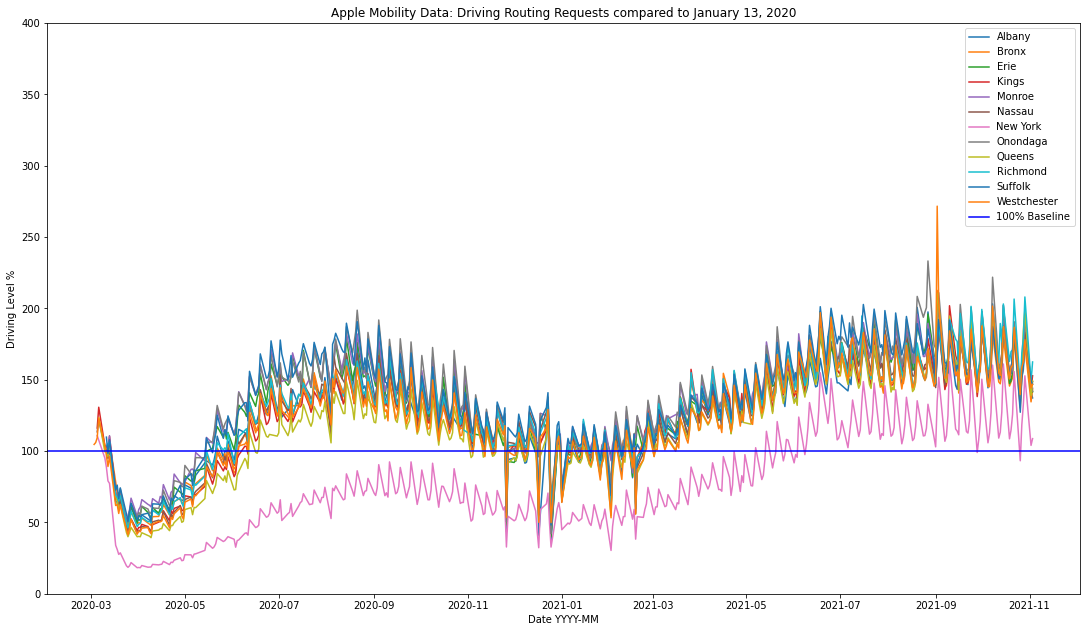

In [246]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for county in df_transit['County'].unique():
    dates = df_driving[df_driving['County'] == county]['SecondDate']
    driving = df_driving[df_driving['County'] == county]['Driving_Level']
    ax.plot(dates,driving)
ax.set_ylim(bottom = 0, top=400)
ax.axhline(y=100, color='b', linestyle='-')
ax.legend(legend_list)
plt.xlabel("Date YYYY-MM")
plt.ylabel("Driving Level %")
plt.title("Apple Mobility Data: Driving Routing Requests compared to January 13, 2020")
plt.show()

Plotting changes in walking mobility over time

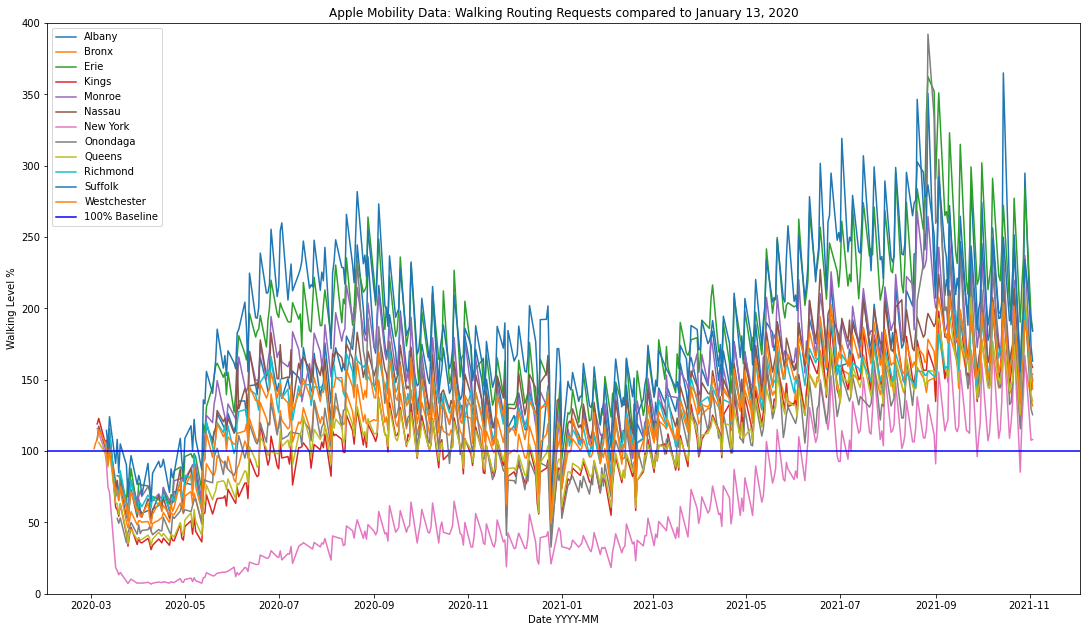

In [247]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for county in df_transit['County'].unique():
    dates = df_walking[df_walking['County'] == county]['SecondDate']
    driving = df_walking[df_walking['County'] == county]['Walking_Level']
    ax.plot(dates,driving)
ax.set_ylim(bottom = 0, top=400)
ax.axhline(y=100, color='b', linestyle='-')
ax.legend(legend_list)
plt.xlabel("Date YYYY-MM")
plt.ylabel("Walking Level %")
plt.title("Apple Mobility Data: Walking Routing Requests compared to January 13, 2020")
plt.show()

Plotting changes in transit mobility over time

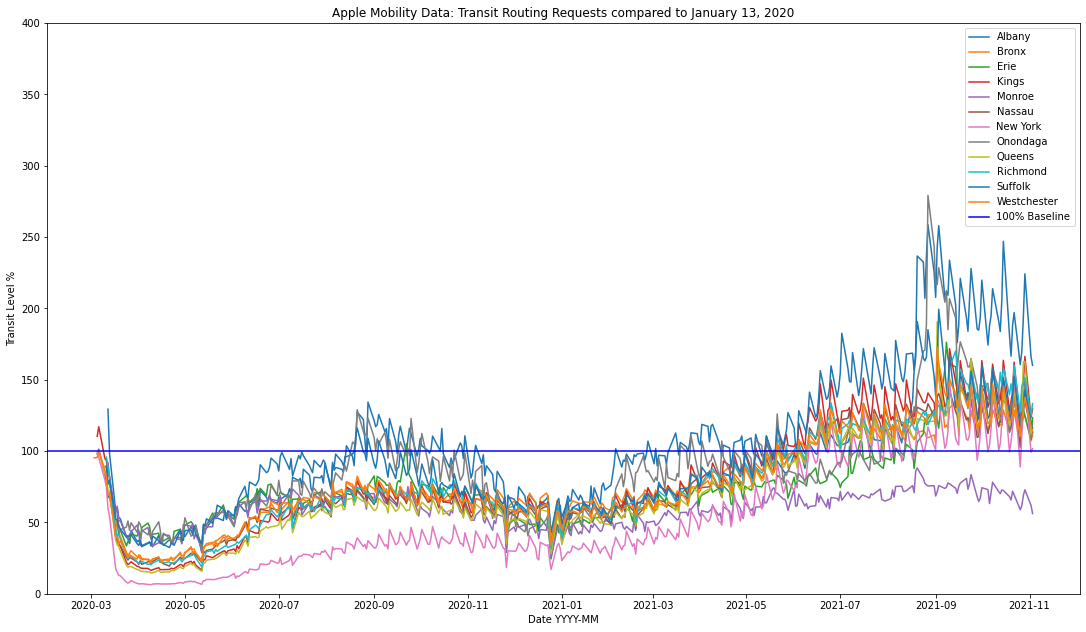

In [248]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for county in df_transit['County'].unique():
    dates = df_transit[df_transit['County'] == county]['SecondDate']
    driving = df_transit[df_transit['County'] == county]['Transit_Level']
    ax.plot(dates,driving)
ax.set_ylim(bottom = 0, top=400)
ax.axhline(y=100, color='b', linestyle='-')
ax.legend(legend_list)
plt.xlabel("Date YYYY-MM")
plt.ylabel("Transit Level %")
plt.title("Apple Mobility Data: Transit Routing Requests compared to January 13, 2020")
plt.show()

Plotting changes in table reservations over time

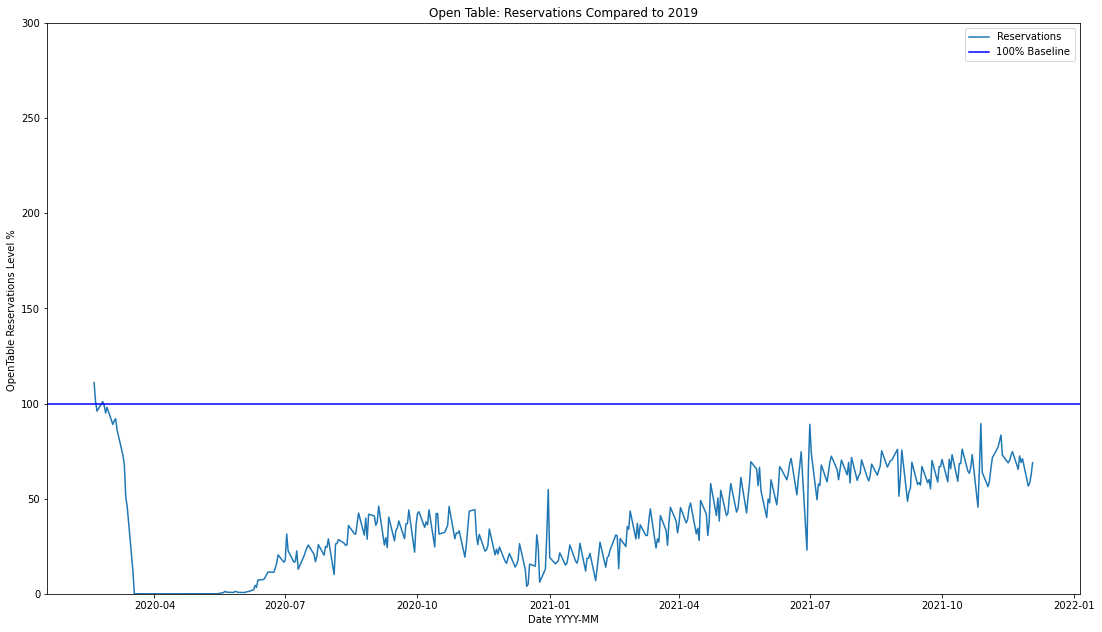

In [249]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
dates = df_table_out['SecondDate']
tables = df_table_out['Table_Level']
ax.plot(dates,tables)
ax.set_ylim(bottom = 0, top=300)
ax.axhline(y=100, color='b', linestyle='-')
ax.legend(['Reservations', '100% Baseline'])
plt.xlabel("Date YYYY-MM")
plt.ylabel("OpenTable Reservations Level % ")
plt.title("Open Table: Reservations Compared to 2019")
plt.show()

Plotting changes in the increase/decrease in new daily covid cases over time

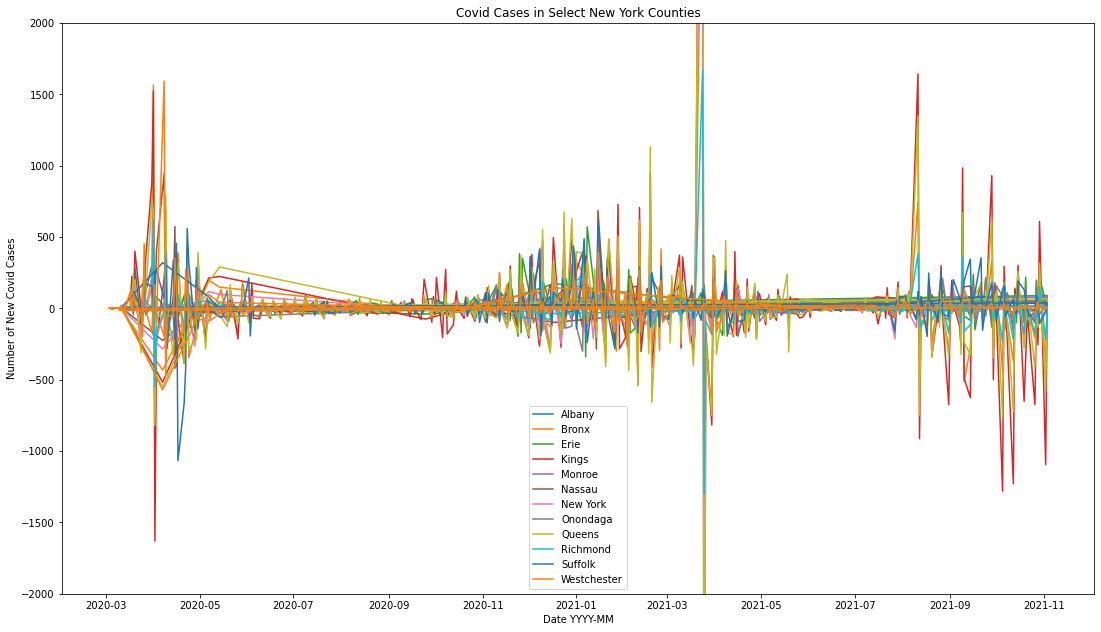

In [250]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for county in df_transit['County'].unique():
    dates = df_all[df_all['County'] == county]['SecondDate']
    driving = df_all[df_all['County'] == county]['Cases_Change']
    ax.plot(dates,driving)
ax.set_ylim(bottom = -2000, top=2000)
#ax.axhline(y=100, color='b', linestyle='-')
ax.legend(df_transit['County'].unique())
plt.xlabel("Date YYYY-MM")
plt.ylabel("Number of New Covid Cases")
plt.title("Covid Cases in Select New York Counties")
plt.show()

In [257]:
df_all.to_csv("merged_filtered.csv", index_label=False)